# Polymarket Analytics Toolkit

Comprehensive analytical functions for exploring Polymarket trading data.

## Features:
- Top traders by volume/trades/PnL
- Top markets by volume/trades/liquidity
- Trader market analysis
- Market statistics and metrics
- Time-based analysis
- Position tracking
- Concentration metrics

In [1]:
from __future__ import annotations

import warnings
from pathlib import Path
import sys

import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

# Configure Polars display
pl.Config.set_tbl_rows(25)
pl.Config.set_tbl_cols(-1)
pl.Config.set_tbl_width_chars(1000)

# Add project root to path
PROJECT_ROOT = Path('..').resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from poly_utils import get_markets, PLATFORM_WALLETS

print("✓ Imports loaded")

✓ Imports loaded


## 1. Load Data

In [2]:
# Load markets
markets_df = get_markets(
    main_file=str(PROJECT_ROOT / 'markets.csv'),
    missing_file=str(PROJECT_ROOT / 'missing_markets.csv')
)
print(f"Loaded {len(markets_df):,} markets")

# Load trades - using 10M latest for faster analysis
# Change to processed/trades.csv for full dataset (194M trades)
TRADES_FILE = PROJECT_ROOT / 'processed' / 'latest_10000000_trades.parquet'

if TRADES_FILE.exists():
    trades = pl.read_parquet(TRADES_FILE)
else:
    # Fallback to full CSV
    print("⚠ Latest trades parquet not found, loading full CSV (this may take time)...")
    trades = pl.scan_csv(PROJECT_ROOT / 'processed' / 'trades.csv').collect(streaming=True)

# Ensure timestamp is datetime
if trades['timestamp'].dtype == pl.Utf8:
    trades = trades.with_columns(pl.col('timestamp').str.to_datetime())

print(f"Loaded {len(trades):,} trades")
print(f"Date range: {trades['timestamp'].min()} to {trades['timestamp'].max()}")
print(f"Total volume: ${trades['usd_amount'].sum():,.2f}")

Loaded 171019 markets from /home/junel/random-walk-studio/polymarket/polymarket/markets.csv
Combined total: 170542 unique markets (sorted by createdAt)
Loaded 170,542 markets
Loaded 10,000,000 trades
Date range: 2025-11-09 05:16:03 to 2025-11-16 05:23:41
Total volume: $846,886,996.22


## 2. Trader Analytics

In [3]:
def get_top_traders_by_volume(trades_df: pl.DataFrame, n: int = 100, exclude_platform: bool = True) -> pl.DataFrame:
    """
    Get top N traders ranked by total USD volume.
    
    Args:
        trades_df: Trades DataFrame
        n: Number of top traders to return
        exclude_platform: Exclude platform wallets (default: True)
    
    Returns:
        DataFrame with trader stats sorted by volume
    """
    result = (
        trades_df
        .group_by('maker')
        .agg(
            pl.len().alias('num_trades'),
            pl.col('usd_amount').sum().alias('total_volume'),
            pl.col('usd_amount').mean().alias('avg_trade_size'),
            pl.col('usd_amount').median().alias('median_trade_size'),
            pl.col('market_id').n_unique().alias('unique_markets'),
            pl.col('maker_direction').eq('BUY').mean().alias('buy_ratio'),
            pl.col('timestamp').min().alias('first_trade'),
            pl.col('timestamp').max().alias('last_trade'),
        )
        .with_columns(
            (pl.col('last_trade') - pl.col('first_trade')).alias('active_days')
        )
        .sort('total_volume', descending=True)
    )
    
    if exclude_platform:
        result = result.filter(~pl.col('maker').is_in(PLATFORM_WALLETS))
    
    return result.head(n)


def get_top_traders_by_trades(trades_df: pl.DataFrame, n: int = 100, exclude_platform: bool = True) -> pl.DataFrame:
    """
    Get top N traders ranked by number of trades.
    """
    result = (
        trades_df
        .group_by('maker')
        .agg(
            pl.len().alias('num_trades'),
            pl.col('usd_amount').sum().alias('total_volume'),
            pl.col('usd_amount').mean().alias('avg_trade_size'),
            pl.col('market_id').n_unique().alias('unique_markets'),
            pl.col('maker_direction').eq('BUY').mean().alias('buy_ratio'),
        )
        .sort('num_trades', descending=True)
    )
    
    if exclude_platform:
        result = result.filter(~pl.col('maker').is_in(PLATFORM_WALLETS))
    
    return result.head(n)


def get_trader_pnl(trades_df: pl.DataFrame, trader_address: str) -> pl.DataFrame:
    """
    Calculate PnL for a specific trader across all positions.
    
    Returns per-market PnL with realized and unrealized components.
    """
    trader_trades = trades_df.filter(pl.col('maker') == trader_address.lower())
    
    # Calculate last price per market/side
    trader_trades = trader_trades.with_columns(
        pl.col('price')
          .sort_by('timestamp')
          .last()
          .over(['market_id', 'nonusdc_side'])
          .alias('last_price')
    )
    
    # Mark settled positions (price at 0 or 1)
    trader_trades = trader_trades.with_columns(
        pl.when(pl.col('last_price') > 0.98).then(pl.lit(1.0))
          .when(pl.col('last_price') < 0.02).then(pl.lit(0.0))
          .otherwise(pl.col('last_price'))
          .alias('last_price')
    )
    
    # Aggregate by market and side
    pnl = (
        trader_trades
        .group_by(['market_id', 'nonusdc_side'])
        .agg(
            # Cash flows
            (pl.when(pl.col('maker_direction') == 'BUY')
               .then(pl.col('usd_amount'))
               .otherwise(0.0)).sum().alias('buy_usd'),
            (pl.when(pl.col('maker_direction') == 'SELL')
               .then(pl.col('usd_amount'))
               .otherwise(0.0)).sum().alias('sell_usd'),
            
            # Token flows
            (pl.when(pl.col('maker_direction') == 'BUY')
               .then(pl.col('token_amount'))
               .otherwise(0.0)).sum().alias('buy_tokens'),
            (pl.when(pl.col('maker_direction') == 'SELL')
               .then(pl.col('token_amount'))
               .otherwise(0.0)).sum().alias('sell_tokens'),
            
            pl.len().alias('trades'),
            pl.col('last_price').last().alias('last_price'),
        )
        .with_columns(
            (pl.col('sell_usd') - pl.col('buy_usd')).alias('cash_pnl'),
            (pl.col('buy_tokens') - pl.col('sell_tokens')).alias('inventory'),
        )
        .with_columns(
            (pl.col('inventory') * pl.col('last_price')).alias('unrealized_pnl'),
        )
        .with_columns(
            (pl.col('cash_pnl') + pl.col('unrealized_pnl')).alias('total_pnl'),
        )
        .sort('total_pnl', descending=True)
    )
    
    # Join market info
    pnl = pnl.join(
        markets_df.select(['id', 'question', 'answer1', 'answer2']).rename({'id': 'market_id'}),
        on='market_id',
        how='left'
    )
    
    return pnl


# Example usage
print("\n=== Top 10 Traders by Volume ===")
top_volume = get_top_traders_by_volume(trades, n=10)
print(top_volume)

print("\n=== Top 10 Traders by Number of Trades ===")
top_trades = get_top_traders_by_trades(trades, n=10)
print(top_trades)


=== Top 10 Traders by Volume ===
shape: (10, 10)
┌─────────────────────────────────┬────────────┬──────────────┬────────────────┬───────────────────┬────────────────┬───────────┬─────────────────────┬─────────────────────┬────────────────┐
│ maker                           ┆ num_trades ┆ total_volume ┆ avg_trade_size ┆ median_trade_size ┆ unique_markets ┆ buy_ratio ┆ first_trade         ┆ last_trade          ┆ active_days    │
│ ---                             ┆ ---        ┆ ---          ┆ ---            ┆ ---               ┆ ---            ┆ ---       ┆ ---                 ┆ ---                 ┆ ---            │
│ str                             ┆ u32        ┆ f64          ┆ f64            ┆ f64               ┆ u32            ┆ f64       ┆ datetime[μs]        ┆ datetime[μs]        ┆ duration[μs]   │
╞═════════════════════════════════╪════════════╪══════════════╪════════════════╪═══════════════════╪════════════════╪═══════════╪═════════════════════╪═════════════════════╪═════════════

## 3. Market Analytics

In [4]:
def get_top_markets_by_volume(trades_df: pl.DataFrame, markets_df: pl.DataFrame, n: int = 100) -> pl.DataFrame:
    """
    Get top N markets ranked by total USD volume.
    """
    result = (
        trades_df
        .group_by('market_id')
        .agg(
            pl.len().alias('num_trades'),
            pl.col('usd_amount').sum().alias('total_volume'),
            pl.col('usd_amount').mean().alias('avg_trade_size'),
            pl.col('maker').n_unique().alias('unique_traders'),
            pl.col('price').mean().alias('avg_price'),
            pl.col('price').std().alias('price_volatility'),
            pl.col('timestamp').min().alias('first_trade'),
            pl.col('timestamp').max().alias('last_trade'),
        )
        .sort('total_volume', descending=True)
        .head(n)
    )
    
    # Join market metadata
    result = result.join(
        markets_df.select(['id', 'question', 'answer1', 'answer2', 'ticker', 'closedTime'])
                  .rename({'id': 'market_id'}),
        on='market_id',
        how='left'
    )
    
    return result


def get_top_markets_by_trades(trades_df: pl.DataFrame, markets_df: pl.DataFrame, n: int = 100) -> pl.DataFrame:
    """
    Get top N markets ranked by number of trades.
    """
    result = (
        trades_df
        .group_by('market_id')
        .agg(
            pl.len().alias('num_trades'),
            pl.col('usd_amount').sum().alias('total_volume'),
            pl.col('maker').n_unique().alias('unique_traders'),
            pl.col('price').mean().alias('avg_price'),
        )
        .sort('num_trades', descending=True)
        .head(n)
    )
    
    result = result.join(
        markets_df.select(['id', 'question', 'ticker']).rename({'id': 'market_id'}),
        on='market_id',
        how='left'
    )
    
    return result


def get_market_liquidity_metrics(trades_df: pl.DataFrame, markets_df: pl.DataFrame, n: int = 100) -> pl.DataFrame:
    """
    Calculate liquidity metrics for top markets.
    Includes bid-ask spread proxies and depth indicators.
    """
    result = (
        trades_df
        .group_by('market_id')
        .agg(
            pl.len().alias('num_trades'),
            pl.col('usd_amount').sum().alias('total_volume'),
            pl.col('maker').n_unique().alias('unique_traders'),
            
            # Liquidity indicators
            pl.col('price').std().alias('price_volatility'),
            (pl.col('price').quantile(0.75) - pl.col('price').quantile(0.25)).alias('price_iqr'),
            pl.col('usd_amount').median().alias('median_trade_size'),
            pl.col('usd_amount').quantile(0.95).alias('p95_trade_size'),
            
            # Time-based metrics
            pl.col('timestamp').min().alias('first_trade'),
            pl.col('timestamp').max().alias('last_trade'),
        )
        .with_columns(
            # Trades per day
            (pl.col('num_trades') / 
             ((pl.col('last_trade') - pl.col('first_trade')).dt.total_seconds() / 86400).fill_null(1)
            ).alias('trades_per_day')
        )
        .sort('total_volume', descending=True)
        .head(n)
    )
    
    result = result.join(
        markets_df.select(['id', 'question', 'ticker']).rename({'id': 'market_id'}),
        on='market_id',
        how='left'
    )
    
    return result


def get_market_price_history(trades_df: pl.DataFrame, market_id: int, side: str = 'token1') -> pl.DataFrame:
    """
    Get price history for a specific market and side.
    
    Args:
        trades_df: Trades DataFrame
        market_id: Market ID
        side: 'token1' or 'token2'
    """
    return (
        trades_df
        .filter(
            (pl.col('market_id') == market_id) &
            (pl.col('nonusdc_side') == side)
        )
        .select(['timestamp', 'price', 'usd_amount', 'maker_direction'])
        .sort('timestamp')
    )


# Example usage
print("\n=== Top 10 Markets by Volume ===")
top_markets = get_top_markets_by_volume(trades, markets_df, n=10)
print(top_markets.select(['question', 'total_volume', 'num_trades', 'unique_traders']))

print("\n=== Top 10 Markets by Liquidity ===")
liquid_markets = get_market_liquidity_metrics(trades, markets_df, n=10)
print(liquid_markets.select(['question', 'total_volume', 'trades_per_day', 'price_volatility']))


=== Top 10 Markets by Volume ===
shape: (10, 4)
┌─────────────────────────────────┬──────────────┬────────────┬────────────────┐
│ question                        ┆ total_volume ┆ num_trades ┆ unique_traders │
│ ---                             ┆ ---          ┆ ---        ┆ ---            │
│ str                             ┆ f64          ┆ u32        ┆ u32            │
╞═════════════════════════════════╪══════════════╪════════════╪════════════════╡
│ LoL: T1 vs KT Rolster (BO5)     ┆ 2.3927e7     ┆ 62921      ┆ 11376          │
│ Fed increases interest rates b… ┆ 1.4127e7     ┆ 37647      ┆ 3958           │
│ Will the government shutdown e… ┆ 1.2907e7     ┆ 44810      ┆ 4615           │
│ Fed decreases interest rates b… ┆ 1.1667e7     ┆ 48556      ┆ 5048           │
│ Will the Government shutdown e… ┆ 8.9632e6     ┆ 48141      ┆ 6303           │
│ Eagles vs. Packers              ┆ 8.1257e6     ┆ 17349      ┆ 3153           │
│ Will the Government shutdown e… ┆ 7.7794e6     ┆ 37908    

## 4. Trader-Market Analytics

In [5]:
def get_markets_by_trader(trades_df: pl.DataFrame, markets_df: pl.DataFrame, trader_address: str) -> pl.DataFrame:
    """
    Get all markets traded by a specific trader with their performance.
    """
    trader_markets = (
        trades_df
        .filter(pl.col('maker') == trader_address.lower())
        .group_by('market_id')
        .agg(
            pl.len().alias('num_trades'),
            pl.col('usd_amount').sum().alias('total_volume'),
            pl.col('usd_amount').mean().alias('avg_trade_size'),
            pl.col('maker_direction').eq('BUY').mean().alias('buy_ratio'),
            pl.col('price').mean().alias('avg_price'),
            pl.col('timestamp').min().alias('first_trade'),
            pl.col('timestamp').max().alias('last_trade'),
        )
        .sort('total_volume', descending=True)
    )
    
    # Join market info
    trader_markets = trader_markets.join(
        markets_df.select(['id', 'question', 'answer1', 'answer2', 'ticker'])
                  .rename({'id': 'market_id'}),
        on='market_id',
        how='left'
    )
    
    return trader_markets


def get_traders_by_market(trades_df: pl.DataFrame, market_id: int, n: int = 100) -> pl.DataFrame:
    """
    Get top traders in a specific market.
    """
    return (
        trades_df
        .filter(pl.col('market_id') == market_id)
        .group_by('maker')
        .agg(
            pl.len().alias('num_trades'),
            pl.col('usd_amount').sum().alias('total_volume'),
            pl.col('maker_direction').eq('BUY').mean().alias('buy_ratio'),
            pl.col('price').mean().alias('avg_price'),
            pl.col('timestamp').min().alias('first_trade'),
            pl.col('timestamp').max().alias('last_trade'),
        )
        .sort('total_volume', descending=True)
        .head(n)
    )


def get_trader_market_concentration(trades_df: pl.DataFrame, trader_address: str) -> dict:
    """
    Calculate concentration metrics for a trader's market participation.
    
    Returns:
        Dictionary with concentration metrics
    """
    trader_trades = trades_df.filter(pl.col('maker') == trader_address.lower())
    
    market_volumes = (
        trader_trades
        .group_by('market_id')
        .agg(pl.col('usd_amount').sum().alias('volume'))
        .sort('volume', descending=True)
    )
    
    total_volume = market_volumes['volume'].sum()
    
    return {
        'total_volume': total_volume,
        'num_markets': len(market_volumes),
        'top_market_share': market_volumes['volume'][0] / total_volume if len(market_volumes) > 0 else 0,
        'top_5_market_share': market_volumes['volume'][:5].sum() / total_volume if len(market_volumes) >= 5 else 1.0,
        'top_10_market_share': market_volumes['volume'][:10].sum() / total_volume if len(market_volumes) >= 10 else 1.0,
    }


# Example: Get top trader's markets
if len(top_volume) > 0:
    top_trader = top_volume['maker'][0]
    print(f"\n=== Markets for Top Trader: {top_trader[:10]}... ===")
    trader_markets = get_markets_by_trader(trades, markets_df, top_trader)
    print(trader_markets.select(['question', 'num_trades', 'total_volume', 'buy_ratio']).head(10))
    
    print(f"\n=== Concentration Metrics for {top_trader[:10]}... ===")
    concentration = get_trader_market_concentration(trades, top_trader)
    for key, value in concentration.items():
        print(f"{key}: {value}")


=== Markets for Top Trader: 0x31519628... ===
shape: (10, 4)
┌─────────────────────────────────┬────────────┬───────────────┬───────────┐
│ question                        ┆ num_trades ┆ total_volume  ┆ buy_ratio │
│ ---                             ┆ ---        ┆ ---           ┆ ---       │
│ str                             ┆ u32        ┆ f64           ┆ f64       │
╞═════════════════════════════════╪════════════╪═══════════════╪═══════════╡
│ Devils vs. Capitals             ┆ 119        ┆ 1.5959e6      ┆ 0.991597  │
│ LoL: T1 vs KT Rolster (BO5)     ┆ 1887       ┆ 1.4140e6      ┆ 1.0       │
│ LoL: T1 vs KT Rolster - Game 3… ┆ 383        ┆ 858754.372994 ┆ 1.0       │
│ Nuggets vs. Kings               ┆ 367        ┆ 784411.554442 ┆ 1.0       │
│ Will KT Rolster win LoL Worlds… ┆ 223        ┆ 558422.083672 ┆ 1.0       │
│ Will T1 win LoL Worlds 2025?    ┆ 367        ┆ 540640.370032 ┆ 1.0       │
│ LoL: T1 vs KT Rolster - Game 1… ┆ 429        ┆ 455761.831021 ┆ 1.0       │
│ Eagles vs. P

## 5. Time-Based Analytics

In [6]:
def get_daily_trading_stats(trades_df: pl.DataFrame) -> pl.DataFrame:
    """
    Get daily trading statistics.
    """
    return (
        trades_df
        .with_columns(
            pl.col('timestamp').dt.date().alias('date')
        )
        .group_by('date')
        .agg(
            pl.len().alias('num_trades'),
            pl.col('usd_amount').sum().alias('total_volume'),
            pl.col('usd_amount').mean().alias('avg_trade_size'),
            pl.col('maker').n_unique().alias('unique_traders'),
            pl.col('market_id').n_unique().alias('unique_markets'),
        )
        .sort('date')
    )


def get_hourly_trading_pattern(trades_df: pl.DataFrame) -> pl.DataFrame:
    """
    Get trading activity by hour of day (UTC).
    """
    return (
        trades_df
        .with_columns(
            pl.col('timestamp').dt.hour().alias('hour')
        )
        .group_by('hour')
        .agg(
            pl.len().alias('num_trades'),
            pl.col('usd_amount').sum().alias('total_volume'),
            pl.col('usd_amount').mean().alias('avg_trade_size'),
        )
        .sort('hour')
    )


def get_weekly_active_traders(trades_df: pl.DataFrame) -> pl.DataFrame:
    """
    Get weekly active trader counts.
    """
    return (
        trades_df
        .with_columns(
            pl.col('timestamp').dt.truncate('1w').alias('week')
        )
        .group_by('week')
        .agg(
            pl.col('maker').n_unique().alias('unique_traders'),
            pl.len().alias('num_trades'),
            pl.col('usd_amount').sum().alias('total_volume'),
        )
        .sort('week')
    )


def get_new_vs_returning_traders(trades_df: pl.DataFrame, period: str = '1d') -> pl.DataFrame:
    """
    Analyze new vs returning traders by time period.
    
    Args:
        period: '1d', '1w', '1mo' for daily, weekly, monthly
    """
    # Get first trade per trader
    first_trades = (
        trades_df
        .group_by('maker')
        .agg(pl.col('timestamp').min().alias('first_trade'))
    )
    
    # Join back and categorize
    trades_with_first = trades_df.join(first_trades, on='maker')
    
    return (
        trades_with_first
        .with_columns([
            pl.col('timestamp').dt.truncate(period).alias('period'),
            pl.col('first_trade').dt.truncate(period).alias('first_period'),
        ])
        .with_columns(
            (pl.col('period') == pl.col('first_period')).alias('is_new')
        )
        .group_by('period')
        .agg(
            pl.col('maker').filter(pl.col('is_new')).n_unique().alias('new_traders'),
            pl.col('maker').filter(~pl.col('is_new')).n_unique().alias('returning_traders'),
            pl.len().alias('total_trades'),
            pl.col('usd_amount').sum().alias('total_volume'),
        )
        .sort('period')
    )


# Example usage
print("\n=== Daily Trading Stats (Last 7 Days) ===")
daily_stats = get_daily_trading_stats(trades)
print(daily_stats.tail(7))

print("\n=== Hourly Trading Pattern ===")
hourly_pattern = get_hourly_trading_pattern(trades)
print(hourly_pattern)


=== Daily Trading Stats (Last 7 Days) ===
shape: (7, 6)
┌────────────┬────────────┬──────────────┬────────────────┬────────────────┬────────────────┐
│ date       ┆ num_trades ┆ total_volume ┆ avg_trade_size ┆ unique_traders ┆ unique_markets │
│ ---        ┆ ---        ┆ ---          ┆ ---            ┆ ---            ┆ ---            │
│ date       ┆ u32        ┆ f64          ┆ f64            ┆ u32            ┆ u32            │
╞════════════╪════════════╪══════════════╪════════════════╪════════════════╪════════════════╡
│ 2025-11-10 ┆ 1303963    ┆ 9.6000e7     ┆ 73.622069      ┆ 71481          ┆ 7048           │
│ 2025-11-11 ┆ 1417768    ┆ 9.4571e7     ┆ 66.704383      ┆ 73171          ┆ 7401           │
│ 2025-11-12 ┆ 1529402    ┆ 1.1064e8     ┆ 72.339855      ┆ 75367          ┆ 7599           │
│ 2025-11-13 ┆ 1628959    ┆ 1.4355e8     ┆ 88.125674      ┆ 77134          ┆ 7513           │
│ 2025-11-14 ┆ 1445654    ┆ 1.1841e8     ┆ 81.910521      ┆ 75257          ┆ 7706           │
│ 2

## 6. Advanced Analytics

In [7]:
def get_whale_trades(trades_df: pl.DataFrame, min_size: float = 10000, n: int = 100) -> pl.DataFrame:
    """
    Get largest trades (whales).
    
    Args:
        min_size: Minimum USD amount to be considered a whale trade
        n: Number of trades to return
    """
    return (
        trades_df
        .filter(pl.col('usd_amount') >= min_size)
        .sort('usd_amount', descending=True)
        .head(n)
    )


def get_market_momentum(trades_df: pl.DataFrame, market_id: int, hours: int = 24) -> dict:
    """
    Calculate recent momentum for a market.
    
    Returns:
        Dictionary with momentum metrics
    """
    cutoff_time = trades_df['timestamp'].max() - pl.duration(hours=hours)
    
    recent = trades_df.filter(
        (pl.col('market_id') == market_id) &
        (pl.col('timestamp') >= cutoff_time)
    )
    
    if len(recent) == 0:
        return {'no_data': True}
    
    return {
        'num_trades': len(recent),
        'volume': recent['usd_amount'].sum(),
        'buy_volume': recent.filter(pl.col('taker_direction') == 'BUY')['usd_amount'].sum(),
        'sell_volume': recent.filter(pl.col('taker_direction') == 'SELL')['usd_amount'].sum(),
        'avg_price': recent['price'].mean(),
        'price_change': recent['price'].tail(1).item() - recent['price'].head(1).item() if len(recent) > 1 else 0,
        'unique_traders': recent['maker'].n_unique(),
    }


def get_trader_win_rate(trades_df: pl.DataFrame, trader_address: str, min_positions: int = 5) -> pl.DataFrame:
    """
    Calculate win rate for a trader based on closed positions.
    
    A position is considered closed if the final price is 0 or 1.
    """
    pnl = get_trader_pnl(trades_df, trader_address)
    
    # Filter for closed positions only
    closed = pnl.filter(
        (pl.col('last_price').is_in([0.0, 1.0])) &
        (pl.col('inventory').abs() < 0.01)  # Fully closed
    )
    
    if len(closed) < min_positions:
        return pl.DataFrame({
            'message': [f'Not enough closed positions (need {min_positions}, have {len(closed)})']
        })
    
    total_positions = len(closed)
    winning_positions = len(closed.filter(pl.col('total_pnl') > 0))
    losing_positions = len(closed.filter(pl.col('total_pnl') < 0))
    
    avg_win = closed.filter(pl.col('total_pnl') > 0)['total_pnl'].mean() if winning_positions > 0 else 0
    avg_loss = closed.filter(pl.col('total_pnl') < 0)['total_pnl'].mean() if losing_positions > 0 else 0
    
    return pl.DataFrame({
        'metric': ['Total Positions', 'Winning Positions', 'Losing Positions', 'Win Rate', 
                   'Avg Win', 'Avg Loss', 'Profit Factor', 'Total PnL'],
        'value': [
            total_positions,
            winning_positions,
            losing_positions,
            winning_positions / total_positions if total_positions > 0 else 0,
            avg_win,
            avg_loss,
            abs(avg_win / avg_loss) if avg_loss != 0 else 0,
            closed['total_pnl'].sum(),
        ]
    })


def get_price_impact_analysis(trades_df: pl.DataFrame, market_id: int) -> pl.DataFrame:
    """
    Analyze price impact of different trade sizes.
    """
    market_trades = (
        trades_df
        .filter(pl.col('market_id') == market_id)
        .sort('timestamp')
        .with_columns(
            pl.col('price').shift(1).alias('prev_price')
        )
        .with_columns(
            (pl.col('price') - pl.col('prev_price')).alias('price_change')
        )
        .filter(pl.col('prev_price').is_not_null())
    )
    
    # Bin by trade size using when/then instead of cut
    return (
        market_trades
        .with_columns(
            pl.when(pl.col('usd_amount') < 100).then(pl.lit('<100'))
              .when(pl.col('usd_amount') < 500).then(pl.lit('100-500'))
              .when(pl.col('usd_amount') < 1000).then(pl.lit('500-1k'))
              .when(pl.col('usd_amount') < 5000).then(pl.lit('1k-5k'))
              .when(pl.col('usd_amount') < 10000).then(pl.lit('5k-10k'))
              .otherwise(pl.lit('>10k'))
              .alias('size_bucket')
        )
        .group_by('size_bucket')
        .agg(
            pl.len().alias('num_trades'),
            pl.col('price_change').abs().mean().alias('avg_price_impact'),
            pl.col('usd_amount').mean().alias('avg_size'),
        )
        .sort('avg_size')
    )


# Example usage
print("\n=== Top 10 Whale Trades ===")
whales = get_whale_trades(trades, min_size=50000, n=10)
print(whales.select(['timestamp', 'maker', 'market_id', 'usd_amount', 'price']))


=== Top 10 Whale Trades ===
shape: (10, 5)
┌─────────────────────┬─────────────────────────────────┬───────────┬───────────────┬──────────┐
│ timestamp           ┆ maker                           ┆ market_id ┆ usd_amount    ┆ price    │
│ ---                 ┆ ---                             ┆ ---       ┆ ---           ┆ ---      │
│ datetime[μs]        ┆ str                             ┆ i64       ┆ f64           ┆ f64      │
╞═════════════════════╪═════════════════════════════════╪═══════════╪═══════════════╪══════════╡
│ 2025-11-16 03:26:33 ┆ 0x743510ee9f21e24071c4e28edab4… ┆ 639741    ┆ 1.2004e6      ┆ 0.999    │
│ 2025-11-16 03:26:33 ┆ 0x31519628fb5e5aa559d4ba27aa12… ┆ 639741    ┆ 999000.0      ┆ 0.999    │
│ 2025-11-12 02:52:59 ┆ 0x3657862e57070b82a289b5887ec9… ┆ 666316    ┆ 900519.109998 ┆ 0.76     │
│ 2025-11-09 19:07:39 ┆ 0xe639e41094bbeae18f3e6d1790c1… ┆ 570363    ┆ 823014.25     ┆ 0.995    │
│ 2025-11-09 07:07:15 ┆ 0xe639e41094bbeae18f3e6d1790c1… ┆ 570363    ┆ 817224.2     

## 7. Visualization Functions


=== Generating Visualizations ===


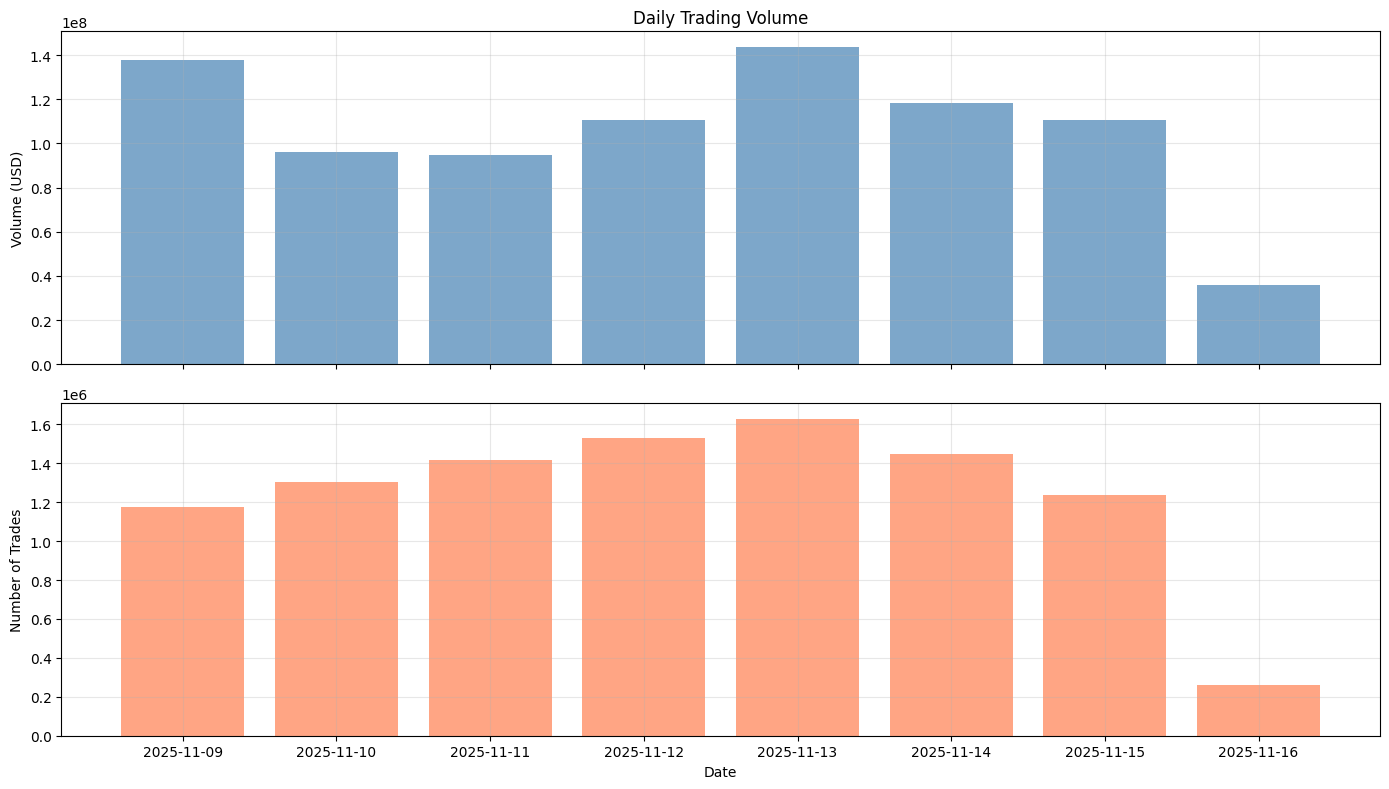

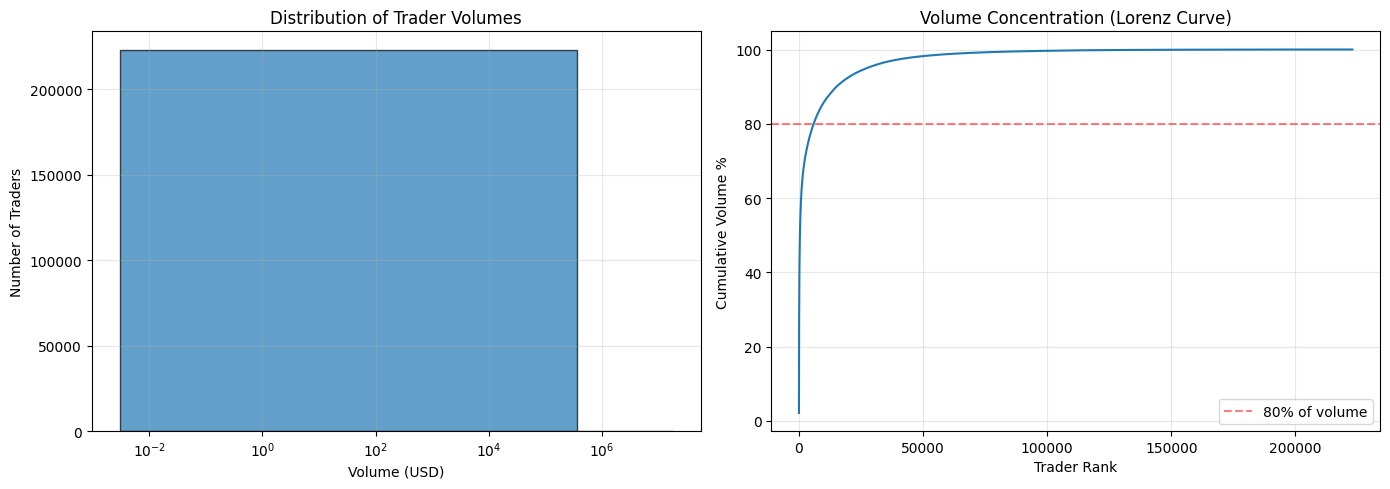

In [8]:
def plot_price_history(trades_df: pl.DataFrame, market_id: int, market_name: str = None):
    """
    Plot price history for a market.
    """
    price_data = get_market_price_history(trades_df, market_id)
    
    if len(price_data) == 0:
        print("No data for this market")
        return
    
    # Convert to pandas for plotting
    price_pd = price_data.to_pandas()
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    
    # Price over time
    ax1.plot(price_pd['timestamp'], price_pd['price'], alpha=0.6, linewidth=0.5)
    ax1.scatter(price_pd['timestamp'], price_pd['price'], 
                c=price_pd['usd_amount'], s=price_pd['usd_amount']/10, 
                alpha=0.3, cmap='viridis')
    ax1.set_ylabel('Price')
    ax1.set_title(f'Price History - {market_name or f"Market {market_id}"}')
    ax1.grid(True, alpha=0.3)
    
    # Volume over time
    ax2.bar(price_pd['timestamp'], price_pd['usd_amount'], width=0.001, alpha=0.6)
    ax2.set_ylabel('Volume (USD)')
    ax2.set_xlabel('Time')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_daily_volume(trades_df: pl.DataFrame):
    """
    Plot daily trading volume.
    """
    daily = get_daily_trading_stats(trades_df).to_pandas()
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    
    ax1.bar(daily['date'], daily['total_volume'], alpha=0.7, color='steelblue')
    ax1.set_ylabel('Volume (USD)')
    ax1.set_title('Daily Trading Volume')
    ax1.grid(True, alpha=0.3)
    
    ax2.bar(daily['date'], daily['num_trades'], alpha=0.7, color='coral')
    ax2.set_ylabel('Number of Trades')
    ax2.set_xlabel('Date')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_trader_distribution(trades_df: pl.DataFrame):
    """
    Plot distribution of trader volumes.
    """
    trader_volumes = (
        trades_df
        .group_by('maker')
        .agg(pl.col('usd_amount').sum().alias('volume'))
        .to_pandas()
    )
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram
    ax1.hist(trader_volumes['volume'], bins=50, alpha=0.7, edgecolor='black')
    ax1.set_xlabel('Volume (USD)')
    ax1.set_ylabel('Number of Traders')
    ax1.set_title('Distribution of Trader Volumes')
    ax1.set_xscale('log')
    ax1.grid(True, alpha=0.3)
    
    # Cumulative distribution
    sorted_volumes = trader_volumes['volume'].sort_values(ascending=False).reset_index(drop=True)
    cumulative_pct = sorted_volumes.cumsum() / sorted_volumes.sum() * 100
    ax2.plot(range(len(cumulative_pct)), cumulative_pct)
    ax2.set_xlabel('Trader Rank')
    ax2.set_ylabel('Cumulative Volume %')
    ax2.set_title('Volume Concentration (Lorenz Curve)')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=80, color='r', linestyle='--', alpha=0.5, label='80% of volume')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()


# Example visualizations
print("\n=== Generating Visualizations ===")
plot_daily_volume(trades)
plot_trader_distribution(trades)

## 8. Export Functions

In [9]:
def export_top_traders(trades_df: pl.DataFrame, output_path: str, n: int = 1000):
    """
    Export top N traders to CSV.
    """
    top_traders = get_top_traders_by_volume(trades_df, n=n)
    top_traders.write_csv(output_path)
    print(f"✓ Exported {len(top_traders)} traders to {output_path}")


def export_top_markets(trades_df: pl.DataFrame, markets_df: pl.DataFrame, 
                       output_path: str, n: int = 1000):
    """
    Export top N markets to CSV.
    """
    top_markets = get_top_markets_by_volume(trades_df, markets_df, n=n)
    top_markets.write_csv(output_path)
    print(f"✓ Exported {len(top_markets)} markets to {output_path}")


def export_trader_pnl(trades_df: pl.DataFrame, trader_address: str, output_path: str):
    """
    Export detailed PnL breakdown for a trader.
    """
    pnl = get_trader_pnl(trades_df, trader_address)
    pnl.write_csv(output_path)
    print(f"✓ Exported PnL for {trader_address[:10]}... to {output_path}")


# Example exports
# export_top_traders(trades, 'top_1000_traders.csv', n=1000)
# export_top_markets(trades, markets_df, 'top_1000_markets.csv', n=1000)
print("\n✓ Export functions ready to use")


✓ Export functions ready to use


## 9. Custom Analysis Examples

In [10]:
# Example 1: Find traders who only buy or only sell
print("\n=== Traders with Extreme Directional Bias ===")
extreme_bias = (
    trades
    .group_by('maker')
    .agg(
        pl.len().alias('num_trades'),
        pl.col('usd_amount').sum().alias('volume'),
        pl.col('maker_direction').eq('BUY').mean().alias('buy_ratio'),
    )
    .filter(
        (pl.col('num_trades') >= 100) &  # Minimum activity
        ((pl.col('buy_ratio') > 0.95) | (pl.col('buy_ratio') < 0.05))
    )
    .sort('volume', descending=True)
)
print(extreme_bias.head(10))


=== Traders with Extreme Directional Bias ===
shape: (10, 4)
┌─────────────────────────────────┬────────────┬──────────┬───────────┐
│ maker                           ┆ num_trades ┆ volume   ┆ buy_ratio │
│ ---                             ┆ ---        ┆ ---      ┆ ---       │
│ str                             ┆ u32        ┆ f64      ┆ f64       │
╞═════════════════════════════════╪════════════╪══════════╪═══════════╡
│ 0x31519628fb5e5aa559d4ba27aa12… ┆ 9238       ┆ 1.7906e7 ┆ 0.97467   │
│ 0x3657862e57070b82a289b5887ec9… ┆ 871        ┆ 7.2780e6 ┆ 0.995408  │
│ 0xed88d69d689f3e2f6d1f77b2e35d… ┆ 2986       ┆ 7.0181e6 ┆ 0.985934  │
│ 0xd218e474776403a330142299f779… ┆ 50367      ┆ 5.5820e6 ┆ 0.99996   │
│ 0xe8dd7741ccb12350957ec71e9ee3… ┆ 84560      ┆ 5.5265e6 ┆ 0.999515  │
│ 0x16b29c50f2439faf627209b2ac0c… ┆ 7300       ┆ 5.3467e6 ┆ 1.0       │
│ 0xee613b3fc183ee44f9da9c05f53e… ┆ 16857      ┆ 4.8204e6 ┆ 1.0       │
│ 0x2a923d2f6edbc894e76357104e65… ┆ 17801      ┆ 4.8082e6 ┆ 1.0       │
│ 

In [11]:
# Example 2: Find markets with highest trader turnover
print("\n=== Markets with Most Active Trading ===")
active_markets = (
    trades
    .group_by('market_id')
    .agg(
        pl.len().alias('num_trades'),
        pl.col('maker').n_unique().alias('unique_traders'),
        pl.col('usd_amount').sum().alias('volume'),
    )
    .with_columns(
        (pl.col('num_trades') / pl.col('unique_traders')).alias('trades_per_trader')
    )
    .sort('unique_traders', descending=True)
    .head(10)
)

active_markets = active_markets.join(
    markets_df.select(['id', 'question']).rename({'id': 'market_id'}),
    on='market_id',
    how='left'
)
print(active_markets)


=== Markets with Most Active Trading ===
shape: (10, 6)
┌───────────┬────────────┬────────────────┬──────────┬───────────────────┬─────────────────────────────────┐
│ market_id ┆ num_trades ┆ unique_traders ┆ volume   ┆ trades_per_trader ┆ question                        │
│ ---       ┆ ---        ┆ ---            ┆ ---      ┆ ---               ┆ ---                             │
│ i64       ┆ u32        ┆ u32            ┆ f64      ┆ f64               ┆ str                             │
╞═══════════╪════════════╪════════════════╪══════════╪═══════════════════╪═════════════════════════════════╡
│ 660880    ┆ 62921      ┆ 11376          ┆ 2.3927e7 ┆ 5.53103           ┆ LoL: T1 vs KT Rolster (BO5)     │
│ 623603    ┆ 48141      ┆ 6303           ┆ 8.9632e6 ┆ 7.637792          ┆ Will the Government shutdown e… │
│ 623602    ┆ 37908      ┆ 5564           ┆ 7.7794e6 ┆ 6.813084          ┆ Will the Government shutdown e… │
│ 570360    ┆ 48556      ┆ 5048           ┆ 1.1667e7 ┆ 9.618859        

In [12]:
# Example 3: Time of day analysis
print("\n=== Peak Trading Hours (UTC) ===")
hourly = get_hourly_trading_pattern(trades)
peak_hours = hourly.sort('total_volume', descending=True).head(5)
print(peak_hours)


=== Peak Trading Hours (UTC) ===
shape: (5, 4)
┌──────┬────────────┬──────────────┬────────────────┐
│ hour ┆ num_trades ┆ total_volume ┆ avg_trade_size │
│ ---  ┆ ---        ┆ ---          ┆ ---            │
│ i8   ┆ u32        ┆ f64          ┆ f64            │
╞══════╪════════════╪══════════════╪════════════════╡
│ 3    ┆ 426754     ┆ 4.8126e7     ┆ 112.77134      │
│ 2    ┆ 431498     ┆ 4.7559e7     ┆ 110.219415     │
│ 23   ┆ 378258     ┆ 4.1572e7     ┆ 109.90344      │
│ 1    ┆ 416001     ┆ 4.0180e7     ┆ 96.585588      │
│ 12   ┆ 446063     ┆ 3.9243e7     ┆ 87.976829      │
└──────┴────────────┴──────────────┴────────────────┘


## Summary

This notebook provides a comprehensive toolkit for analyzing Polymarket trading data:

### Trader Analytics:
- `get_top_traders_by_volume()` - Top traders by USD volume
- `get_top_traders_by_trades()` - Most active traders
- `get_trader_pnl()` - Calculate trader PnL across all positions
- `get_trader_win_rate()` - Win rate for closed positions

### Market Analytics:
- `get_top_markets_by_volume()` - Top markets by volume
- `get_top_markets_by_trades()` - Most traded markets
- `get_market_liquidity_metrics()` - Liquidity analysis
- `get_market_price_history()` - Price time series
- `get_market_momentum()` - Recent market momentum

### Trader-Market Analytics:
- `get_markets_by_trader()` - All markets for a trader
- `get_traders_by_market()` - Top traders in a market
- `get_trader_market_concentration()` - Portfolio concentration

### Time-Based Analytics:
- `get_daily_trading_stats()` - Daily metrics
- `get_hourly_trading_pattern()` - Intraday patterns
- `get_weekly_active_traders()` - Weekly activity
- `get_new_vs_returning_traders()` - User cohort analysis

### Advanced Analytics:
- `get_whale_trades()` - Large trades
- `get_price_impact_analysis()` - Trade size impact

### Visualizations:
- `plot_price_history()` - Market price charts
- `plot_daily_volume()` - Volume over time
- `plot_trader_distribution()` - Trader concentration

All functions are ready to use - just call them with your data!